In [1]:
!pip install -q opendatasets
!pip install -q statsmodels

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

# Data Loading

In [3]:
od.download("https://www.kaggle.com/datasets/ryanholbrook/ts-course-data")

100%|██████████| 120k/120k [00:00<00:00, 30.9MB/s]

# Data Preparation

In [4]:
industries=["BuildingMaterials", "FoodAndBeverage"]

retail = pd.read_csv(
    '/content/ts-course-data/us-retail-sales.csv',
    usecols = ['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month'
).to_period('D').reindex(columns=industries)

retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)
retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

# Fit the trend

In [10]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True
)
X = dp.in_sample()

# Test on the years 2016 - 2019. It will be easier for us later if we split the date index instead of the dataframe directly
idx_train, idx_test = train_test_split(y.index, test_size=12 * 4, shuffle=False)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [11]:
# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns
)

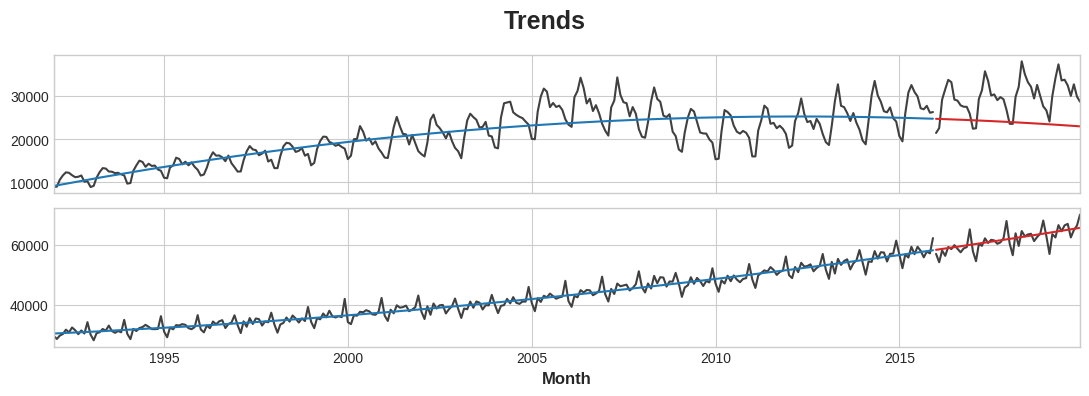

In [12]:
# Plot
axs = y_train.plot(color="0.25", subplots=True, sharex=True)
axs = y_test.plot(color="0.25", subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color="C0", subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color="C3", subplots=True, sharex=True, ax=axs)

for ax in axs:
  ax.legend([])
  _ = plt.suptitle("Trends")

# Stack the dataframe

In [14]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack() # Pivot dataset wide to long
display(X.head())
y = X.pop('Sales') # Grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

# Turn row labels into categorical feature columns with a label encoding

In [15]:
X = X.reset_index('Industries')
# label encoding for industries feature
for colname in X.select_dtypes(['object', 'category']):
  X[colname], _ = X[colname].factorize()

# label encoding for annual seasonality
X['Month'] = X.index.month # values are 1, 2, ... , 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [16]:
# Pivot wide to long (stack) and convert dataframe to series (squeeze)
y_fit = y_fit.stack().squeeze() # trend from training set
y_pred = y_pred.stack().squeeze() # trend from test set

# Create residual (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residual onto predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

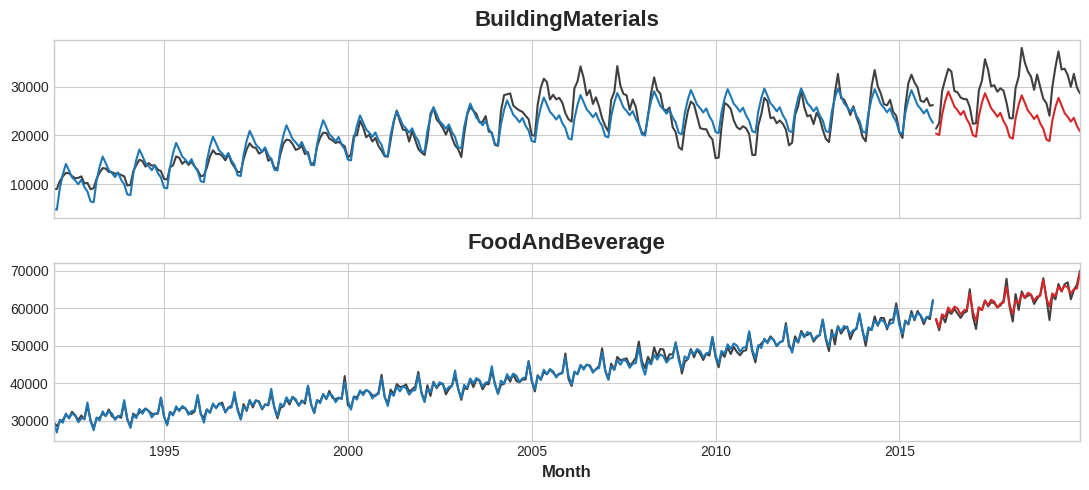

In [17]:
axs = y_train.unstack(['Industries']).plot(
    color="0.25", figsize=(11,5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage']
)
axs = y_test.unstack(['Industries']).plot(
    color="0.25", subplots=True, sharex=True, ax=axs
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color="C0", subplots=True, sharex=True, ax=axs
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color="C3", subplots=True, sharex=True, ax=axs
)
for ax in axs: ax.legend([])